## Electricity Consumption Analysis:  

## Objective of study

In this work, the electricity demand from clients in Portugal, during 2013 and 2014 was studied. 

### Data: The dataset can be downloaded from:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

### Electric Demand:
http://www.think-energy.net/KWvsKWH.htm

## Data Preparation

In [1]:

#pathToFile = r"C:\\path\\to\\file\\"
#pathToFile = r"C:\\Users\\<your username>\\Downloads\\"

pathToFile = r"C:\\Users\\Downloads\\Electricity\\"
fileName = 'LD2011_2014.txt'

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Create dataframe
import pandas as pd
data = pd.read_csv(pathToFile+fileName, sep=";", index_col=0)

In [7]:
data.shape

(140256, 370)

#### As it can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


### Plot the first 2 days of 2012 for the first 2 clients

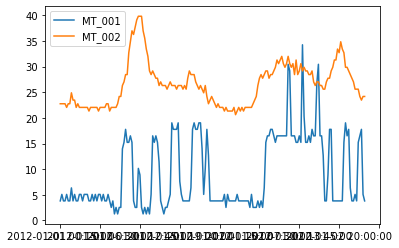

In [10]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

### Data for the analysis

We focus on 2013 and 2014 because these are the years with low number of clients having zero demand

In [11]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [12]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [13]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [14]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = data2013.append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


## Getting average curves per client

In [15]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [17]:
data['hour'] = data.index.map(lambda x: x[11:])

### Getting average curves per client

In [19]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

(96, 349)

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [20]:
average_curves_norm = average_curves/(average_curves.mean())

#### Plot the first 2 and last 2 clients

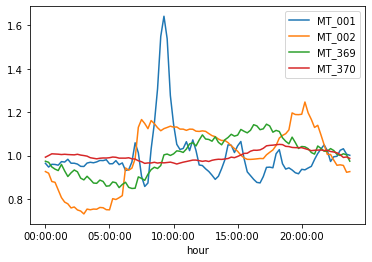

In [21]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normalized curves

In [22]:
X = average_curves_norm.copy()  # We call this normalized curve
X

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
hour,,,,,,,,,,,,,,,,,,,,,
00:00:00,0.964792,0.926674,0.991800,1.140106,1.186498,1.008914,1.170686,0.946572,0.983915,0.948867,...,0.414676,0.748555,0.561491,0.430085,0.471574,1.358632,1.215272,1.170441,0.974307,0.992967
00:15:00,0.947378,0.919117,0.977796,1.099159,1.131703,0.946419,1.118666,0.909376,0.953996,0.924425,...,0.414381,0.662602,0.412336,0.375704,0.423108,1.365299,1.184899,1.223818,0.969266,1.000548
00:30:00,0.960104,0.880744,0.976579,1.061641,1.090238,0.905552,1.081459,0.881217,0.931614,0.908674,...,0.386706,0.561815,0.395294,0.344682,0.386975,1.312627,1.177781,1.211343,0.947969,1.008515
00:45:00,0.959434,0.877243,0.971708,1.030153,1.053960,0.868064,1.056382,0.855331,0.907404,0.885073,...,0.337499,0.499651,0.352628,0.295219,0.377024,1.245171,1.156699,1.189829,0.937889,1.007613
01:00:00,0.956085,0.841989,0.953443,0.975761,1.024347,0.822656,1.030838,0.830275,0.888265,0.869041,...,0.318475,0.422753,0.342066,0.288892,0.369187,1.292298,1.149629,1.167326,0.931284,1.006770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22:45:00,0.996941,0.955618,1.038072,1.347294,1.369364,1.276390,1.319398,1.103961,1.160737,1.097433,...,0.744905,1.202059,1.020236,0.921445,1.301872,1.417178,1.265394,1.204952,1.005845,1.013001
23:00:00,1.024736,0.957767,1.009456,1.293558,1.352292,1.237890,1.297937,1.077426,1.136299,1.073857,...,0.646161,1.090286,0.961514,0.892213,1.210639,1.406155,1.268087,1.186229,1.000981,1.004462
23:15:00,1.031768,0.954925,1.003976,1.238946,1.324550,1.179398,1.261197,1.044397,1.094183,1.031013,...,0.569110,0.988787,0.892510,0.758182,1.033002,1.393548,1.252350,1.174311,1.008670,0.991657


In [23]:
X=X.T
#X = np.array(X.T) # put it on the right format

## Determining the number of clusters and evaluation

#### We shall be using Elbow method and Inertia method for finding the number of clusters

In [24]:
X.shape

(349, 96)

ELBOW METHOD
The motive of the partitioning methods is to define clusters such that the total within-cluster sum of square (WSS) is minimized.

The steps to determine k using Elbow method are as follows:

For, k varying from 1 to let’s say 10, compute the k-means clustering.
For each k, we calculate the total WSS.
Plot the graph of WSS w.r.t each k.
The appropriate number of clusters k is generally considered where a bend (knee) is seen in the plot.
The k from the plot should be chosen such that adding another cluster doesn’t improve the total WSS much.

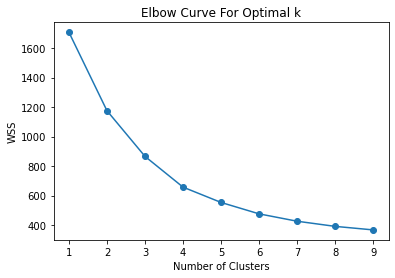

In [25]:
cluster_range = range(1,10)
cluster_wss = []
from sklearn.cluster import KMeans
for num_cluster in cluster_range:
    clusters = KMeans(num_cluster)
    clusters.fit(X)
    cluster_wss.append(clusters.inertia_)
    
plt.xlabel('Number of Clusters')
plt.ylabel('WSS')
plt.plot(cluster_range, cluster_wss, marker = 'o')
plt.title('Elbow Curve For Optimal k')
plt.show()

The curve looks like an elbow. In the above plot, the elbow appears to be at k=3 (i.e., the Sum of squared distances falls suddenly), indicating the optimal k for this dataset is 3.Still, inorder to confirm the same, we have to look for Sillhoute scores.

#### Silhouette Analysis

The silhouette coefficient or silhouette score kmeans is a measure of how similar a data point is within-cluster (cohesion) compared to other clusters (separation). 

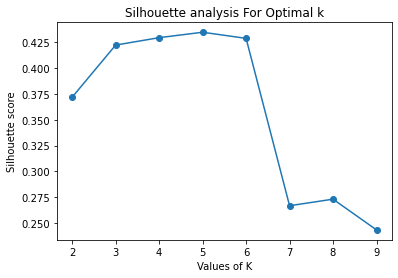

In [26]:
sillhoute_scores = []
n_cluster_list = np.arange(2,10).astype(int)

for n_cluster in n_cluster_list:
    
    kmeans = KMeans(n_clusters=n_cluster)
    cluster_found = kmeans.fit_predict(X)
    sillhoute_scores.append(silhouette_score(X, kmeans.labels_))
plt.plot(n_cluster_list,sillhoute_scores,marker = 'o')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

We see that the silhouette score is maximized at k = 3. So, we will take 3 clusters.

The silhouette Method used in combination with the Elbow Method gives the optimal value of K=3 in for a more confident decision

In [27]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42).fit(X)

In [28]:
kmeans.labels_  # same as kmeans.predict(X)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 1, 1, 0, 2, 1, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1, 2, 1, 2,
       0, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [29]:
kmeans.inertia_

865.96772088043

In [30]:
kmeans.n_iter_

5

In [31]:
kmeans.cluster_centers_

array([[0.6306257 , 0.55918055, 0.50782133, 0.43377031, 0.40986746,
        0.36370367, 0.35050852, 0.34607248, 0.34184812, 0.32953058,
        0.32188435, 0.3180763 , 0.3149388 , 0.30470595, 0.29758018,
        0.29044418, 0.28701158, 0.28132552, 0.27703636, 0.27653823,
        0.27827373, 0.28571354, 0.28627614, 0.28928744, 0.29299286,
        0.32348026, 0.33113314, 0.33204434, 0.33574405, 0.33953624,
        0.34116886, 0.34294662, 0.35190557, 0.39508126, 0.43356208,
        0.49586313, 0.57374462, 0.70161229, 0.77222875, 0.89816799,
        1.0255102 , 1.22111547, 1.30498059, 1.35018164, 1.3704535 ,
        1.39594466, 1.40698714, 1.42486464, 1.41870873, 1.42316854,
        1.44729534, 1.46384222, 1.47989964, 1.55349023, 1.58062594,
        1.59046969, 1.59397328, 1.58950221, 1.59187836, 1.59533547,
        1.59850503, 1.59600636, 1.598877  , 1.6009356 , 1.60401532,
        1.60520237, 1.60557175, 1.60890818, 1.57946049, 1.55657339,
        1.56043904, 1.57000988, 1.56908415, 1.57

In [32]:
from collections import Counter
Counter(kmeans.labels_)

Counter({2: 113, 1: 201, 0: 35})

In [33]:
clusterdf= pd.DataFrame(data=kmeans.labels_, columns=['ClusterNo'])
clusterdf.index = X.index
clusterdf
    

,ClusterNo
MT_001,2
MT_002,2
MT_003,2
MT_004,2
MT_005,2
...,...
MT_366,2
MT_367,2
MT_368,2
MT_369,2


In [34]:
X

hour,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,01:45:00,02:00:00,02:15:00,...,21:30:00,21:45:00,22:00:00,22:15:00,22:30:00,22:45:00,23:00:00,23:15:00,23:30:00,23:45:00
MT_001,0.964792,0.947378,0.960104,0.959434,0.956085,0.972494,0.970485,0.983211,0.965127,0.965127,...,1.030429,1.049852,1.022727,0.973164,0.994931,0.996941,1.024736,1.031768,1.006652,1.001629
MT_002,0.926674,0.919117,0.880744,0.877243,0.841989,0.806701,0.786076,0.778034,0.759108,0.763579,...,1.095834,1.049731,1.005708,1.005500,0.979363,0.955618,0.957767,0.954925,0.923346,0.926570
MT_003,0.991800,0.977796,0.976579,0.971708,0.953443,0.949181,0.954660,0.947354,0.918739,0.925436,...,1.111741,1.101391,1.092867,1.081908,1.069122,1.038072,1.009456,1.003976,0.998497,0.993017
MT_004,1.140106,1.099159,1.061641,1.030153,0.975761,0.920906,0.897345,0.875850,0.855450,0.836217,...,1.502958,1.495640,1.462960,1.422622,1.389845,1.347294,1.293558,1.238946,1.209744,1.175290
MT_005,1.186498,1.131703,1.090238,1.053960,1.024347,0.992994,0.962757,0.934785,0.918994,0.903958,...,1.366081,1.376127,1.382463,1.388340,1.385878,1.369364,1.352292,1.324550,1.272842,1.231541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT_366,1.358632,1.365299,1.312627,1.245171,1.292298,1.246425,1.221937,1.160817,1.096199,0.922938,...,1.361140,1.352362,1.356124,1.300020,1.358302,1.417178,1.406155,1.393548,1.360414,1.324442
MT_367,1.215272,1.184899,1.177781,1.156699,1.149629,1.139513,1.125489,1.092430,1.069030,1.043176,...,1.002055,1.014598,1.021865,1.182977,1.273484,1.265394,1.268087,1.252350,1.247264,1.227273
MT_368,1.170441,1.223818,1.211343,1.189829,1.167326,1.105127,0.993529,0.914299,0.842847,0.789775,...,1.298331,1.280347,1.264828,1.242055,1.223890,1.204952,1.186229,1.174311,1.153788,1.136380
MT_369,0.974307,0.969266,0.947969,0.937889,0.931284,0.959546,0.929746,0.903852,0.920795,0.933955,...,1.033427,1.020555,1.020748,1.032500,1.023658,1.005845,1.000981,1.008670,1.003680,0.974611


In [35]:
df_all = pd.concat([X, clusterdf], axis=1)
df_all

,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,01:45:00,02:00:00,02:15:00,...,21:45:00,22:00:00,22:15:00,22:30:00,22:45:00,23:00:00,23:15:00,23:30:00,23:45:00,ClusterNo
MT_001,0.964792,0.947378,0.960104,0.959434,0.956085,0.972494,0.970485,0.983211,0.965127,0.965127,...,1.049852,1.022727,0.973164,0.994931,0.996941,1.024736,1.031768,1.006652,1.001629,2
MT_002,0.926674,0.919117,0.880744,0.877243,0.841989,0.806701,0.786076,0.778034,0.759108,0.763579,...,1.049731,1.005708,1.005500,0.979363,0.955618,0.957767,0.954925,0.923346,0.926570,2
MT_003,0.991800,0.977796,0.976579,0.971708,0.953443,0.949181,0.954660,0.947354,0.918739,0.925436,...,1.101391,1.092867,1.081908,1.069122,1.038072,1.009456,1.003976,0.998497,0.993017,2
MT_004,1.140106,1.099159,1.061641,1.030153,0.975761,0.920906,0.897345,0.875850,0.855450,0.836217,...,1.495640,1.462960,1.422622,1.389845,1.347294,1.293558,1.238946,1.209744,1.175290,2
MT_005,1.186498,1.131703,1.090238,1.053960,1.024347,0.992994,0.962757,0.934785,0.918994,0.903958,...,1.376127,1.382463,1.388340,1.385878,1.369364,1.352292,1.324550,1.272842,1.231541,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT_366,1.358632,1.365299,1.312627,1.245171,1.292298,1.246425,1.221937,1.160817,1.096199,0.922938,...,1.352362,1.356124,1.300020,1.358302,1.417178,1.406155,1.393548,1.360414,1.324442,2
MT_367,1.215272,1.184899,1.177781,1.156699,1.149629,1.139513,1.125489,1.092430,1.069030,1.043176,...,1.014598,1.021865,1.182977,1.273484,1.265394,1.268087,1.252350,1.247264,1.227273,2
MT_368,1.170441,1.223818,1.211343,1.189829,1.167326,1.105127,0.993529,0.914299,0.842847,0.789775,...,1.280347,1.264828,1.242055,1.223890,1.204952,1.186229,1.174311,1.153788,1.136380,2
MT_369,0.974307,0.969266,0.947969,0.937889,0.931284,0.959546,0.929746,0.903852,0.920795,0.933955,...,1.020555,1.020748,1.032500,1.023658,1.005845,1.000981,1.008670,1.003680,0.974611,2


In [36]:
df_all.index

Index(['MT_001', 'MT_002', 'MT_003', 'MT_004', 'MT_005', 'MT_006', 'MT_007',
       'MT_008', 'MT_009', 'MT_010',
       ...
       'MT_361', 'MT_362', 'MT_363', 'MT_364', 'MT_365', 'MT_366', 'MT_367',
       'MT_368', 'MT_369', 'MT_370'],
      dtype='object', length=349)

Cluster No.: 0
Number of Clients: 35


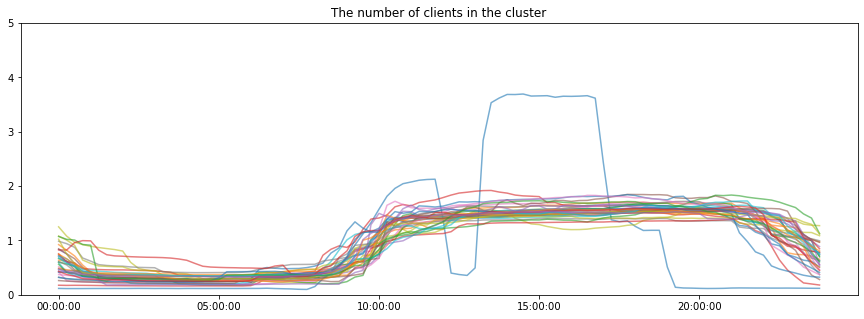

-----------------------------------------------------------------------------------
Cluster No.: 1
Number of Clients: 201


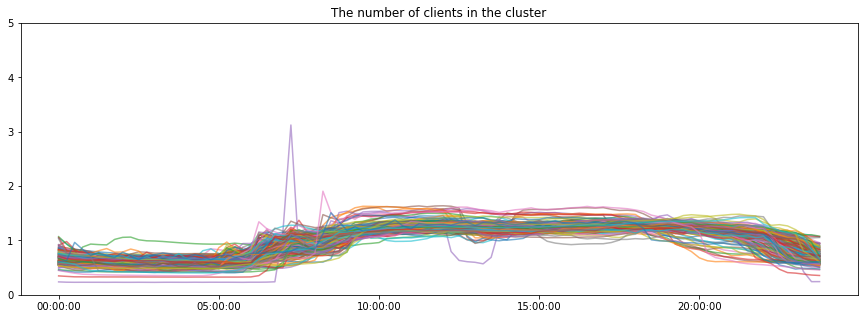

-----------------------------------------------------------------------------------
Cluster No.: 2
Number of Clients: 113


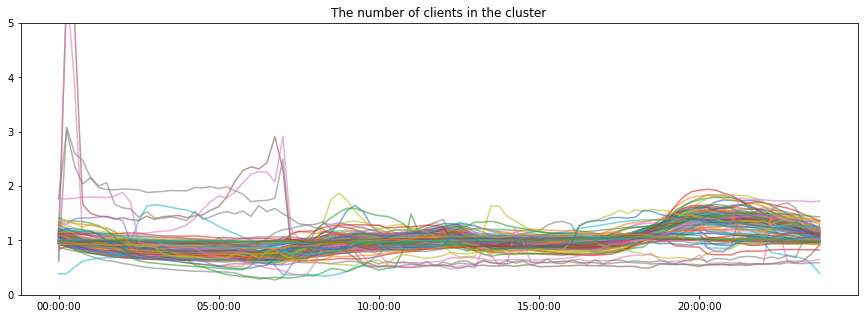

-----------------------------------------------------------------------------------


In [37]:
for ClusterNo in df_all['ClusterNo'].sort_values().unique():
    df_plot = df_all[df_all['ClusterNo']==ClusterNo].T.drop('ClusterNo')
    print('Cluster No.: ' + str(ClusterNo))    
    print('Number of Clients: ' + str(len(df_plot.T)))
    df_plot.plot(figsize=(15,5),alpha=0.6,legend=False, ylim=(0, 5))
    plt.title('The number of clients in the cluster')
    plt.show()
    print('-----------------------------------------------------------------------------------')

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt



In [39]:
cdf= pd.DataFrame(data=kmeans.cluster_centers_)
cdf.columns=X.columns
cdf_f=cdf.T
cdf_f.head(2)

,0,1,2
hour,,,
00:00:00,0.630626,0.677584,1.054918
00:15:00,0.559181,0.658765,1.139126


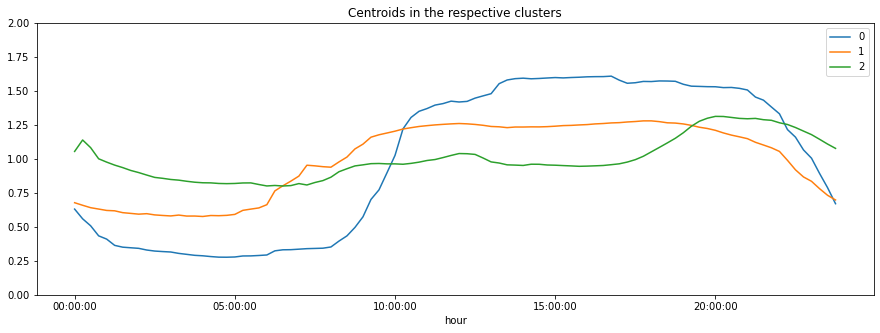

In [40]:
cdf_f.plot(figsize=(15,5), legend=False, ylim=(0, 2))
plt.title('Centroids in the respective clusters')
plt.legend()
plt.show()

In [41]:
client = 'MT_022'
oneClient = data_13_14[client]
#X = [] # a list of arrays, each array being a normalized curve for a day
Z = []
for J in range(2*365):
    Z.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 

In [42]:
oneClient.head()

2013-01-01 00:15:00    31.133250
2013-01-01 00:30:00    28.642590
2013-01-01 00:45:00    27.397260
2013-01-01 01:00:00    24.906600
2013-01-01 01:15:00    24.283935
Name: MT_022, dtype: float64

In [43]:
Z[0]

array([31.13325031, 28.64259029, 27.39726027, 24.90660025, 24.28393524,
       26.15193026, 26.15193026, 24.90660025, 26.77459527, 23.66127024,
       23.66127024, 21.17061021, 23.03860523, 19.30261519, 18.67995019,
       18.67995019, 19.30261519, 19.30261519, 18.67995019, 19.30261519,
       18.05728518, 18.05728518, 17.43462017, 16.81195517, 17.43462017,
       17.43462017, 17.43462017, 17.43462017, 18.67995019, 21.17061021,
       19.30261519, 20.54794521, 19.9252802 , 21.17061021, 20.54794521,
       21.79327522, 24.90660025, 31.13325031, 23.66127024, 19.30261519,
       21.79327522, 20.54794521, 13.69863014, 16.81195517, 15.56662516,
       18.05728518, 18.05728518, 16.81195517, 19.9252802 , 16.81195517,
       18.05728518, 20.54794521, 16.81195517, 18.67995019, 21.17061021,
       19.9252802 , 16.81195517, 16.18929016, 17.43462017, 18.05728518,
       18.67995019, 15.56662516, 18.05728518, 19.30261519, 18.05728518,
       15.56662516, 17.43462017, 18.05728518, 16.18929016, 19.92

In [44]:
#average_curves_norm = average_curves/(average_curves.mean())
client = 'MT_022'
oneClient = data_13_14[client]
Z = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    Z.extend([np.array(oneClient[J*96:(J+1)*96])/np.mean(oneClient[J*96:(J+1)*96])]) 

In [45]:
Z
df_Z=pd.DataFrame(Z)
df_Z

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,1.372998,1.263158,1.208238,1.098398,1.070938,1.153318,1.153318,1.098398,1.180778,1.043478,...,1.372998,1.235698,1.180778,1.180778,1.098398,1.153318,1.208238,1.180778,1.043478,1.070938
1,0.745149,0.745149,0.683053,0.683053,0.745149,0.724450,0.662354,0.765847,0.683053,0.703752,...,0.972833,0.952135,0.890039,0.952135,0.890039,0.827943,0.765847,0.765847,0.786546,0.807245
2,0.697385,0.677460,0.657534,0.637609,0.617684,0.657534,0.577833,0.597758,0.577833,0.557908,...,1.016189,1.016189,1.036115,1.056040,0.936488,0.856787,0.896638,0.856787,0.896638,0.836862
3,0.748768,0.709360,0.709360,0.689655,0.709360,0.650246,0.669951,0.669951,0.689655,0.689655,...,0.965517,0.866995,0.886700,0.866995,0.886700,0.847291,0.945813,0.906404,0.847291,0.788177
4,0.812054,0.786677,0.812054,0.786677,0.735924,0.761301,0.735924,0.735924,0.735924,0.786677,...,1.370341,1.344964,1.116574,1.116574,1.243458,1.192704,1.218081,1.243458,1.065821,1.141951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,0.702691,0.723358,0.702691,0.682024,0.723358,0.702691,0.661356,0.661356,0.661356,0.640689,...,1.260710,1.281378,1.198708,1.260710,1.240043,1.198708,1.240043,1.178041,1.074704,0.950700
726,1.102435,1.036288,0.992191,0.992191,0.926045,0.881948,0.881948,0.903996,0.903996,0.903996,...,1.411116,1.367019,1.344970,1.146532,1.146532,1.058337,1.168581,1.190629,1.058337,0.926045
727,0.787025,0.821244,0.752807,0.787025,0.735698,0.718588,0.735698,0.718588,0.735698,0.701479,...,0.992336,0.941009,0.872572,0.855462,0.906790,0.906790,0.992336,0.992336,0.889681,0.821244
728,0.836795,0.854599,0.872404,0.818991,0.801187,0.783383,0.818991,0.783383,0.818991,0.765579,...,0.925816,0.961424,0.801187,0.729970,0.747774,0.783383,0.836795,0.854599,0.694362,0.676558


X=X.T
df_X=pd.DataFrame(X)
df_X

Z = np.array(X.T) # put it on the right format


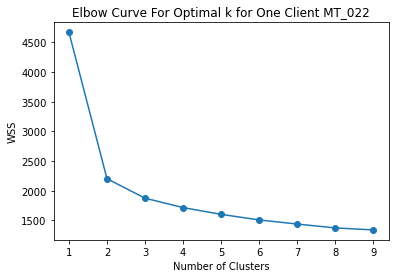

In [46]:
cluster_range = range(1,10)
cluster_wss = []
from sklearn.cluster import KMeans
for num_cluster in cluster_range:
    clusters = KMeans(num_cluster)
    clusters.fit(Z)
    cluster_wss.append(clusters.inertia_)
    
plt.xlabel('Number of Clusters')
plt.ylabel('WSS')
plt.plot(cluster_range, cluster_wss, marker = 'o')
plt.title('Elbow Curve For Optimal k for One Client MT_022')
plt.show()

The curve looks like an elbow. In the above plot, the elbow appears to be at k=2 (i.e., the Sum of squared distances falls suddenly), indicating the optimal k for this dataset is 2. Still, inorder to confirm the same, we have to look for Sillhoute scores.


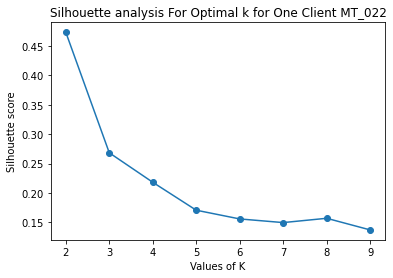

In [47]:
sillhoute_scores = []
n_cluster_list = np.arange(2,10).astype(int)

for n_cluster in n_cluster_list:
    
    kmeans = KMeans(n_clusters=n_cluster)
    cluster_found = kmeans.fit_predict(Z)
    sillhoute_scores.append(silhouette_score(Z, kmeans.labels_))
plt.plot(n_cluster_list,sillhoute_scores,marker = 'o')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k for One Client MT_022')
plt.show()

#### Result: We see that the silhouette score is maximized at k = 2. So, we will take 2 clusters.The silhouette Method used in combination with the Elbow Method gives the optimal value of K=2 in for a more confident decision


In [48]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42).fit(Z)

In [49]:
kmeans.labels_ 

array([0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,

In [50]:
kmeans.inertia_

2203.5728884967493

In [51]:
kmeans.n_iter_

3

In [52]:
kmeans.cluster_centers_

array([[1.19097112, 1.15094668, 1.04451379, 1.01228725, 0.99302399,
        0.98011979, 0.96300427, 0.95964569, 0.94233489, 0.92892984,
        0.91574596, 0.90392837, 0.9131163 , 0.89809869, 0.88949715,
        0.88575285, 0.90389126, 0.89043441, 0.880606  , 0.88523257,
        0.89031239, 0.85859783, 0.81360368, 0.77879999, 0.72875087,
        0.6622582 , 0.62515354, 0.61108469, 0.66043654, 0.7525542 ,
        0.84764619, 0.93765578, 1.00588792, 1.07175231, 1.13796225,
        1.13513648, 1.09483537, 1.13333204, 1.11166697, 1.07555729,
        1.03569995, 0.98227776, 0.966279  , 0.93695585, 0.93178827,
        0.9580528 , 0.97123251, 0.97711992, 0.9197175 , 0.8995167 ,
        0.87425835, 0.84281833, 0.80697517, 0.79158519, 0.82089237,
        0.8224679 , 0.81796353, 0.81642439, 0.81489109, 0.80926961,
        0.79871245, 0.78881554, 0.76799915, 0.74088006, 0.73678229,
        0.74904842, 0.75603447, 0.75805349, 0.75991222, 0.78985764,
        0.84662566, 0.88520814, 1.02186179, 1.23

In [53]:
from collections import Counter
Counter(kmeans.labels_)

Counter({0: 211, 1: 519})

In [54]:
cdf= pd.DataFrame(data=kmeans.cluster_centers_)
cdf.columns=X.columns
cdf_f=cdf.T
cdf_f.head()

,0,1
hour,,
00:00:00,1.190971,0.720590
00:15:00,1.150947,0.699409
00:30:00,1.044514,0.638582
00:45:00,1.012287,0.622282
01:00:00,0.993024,0.611393


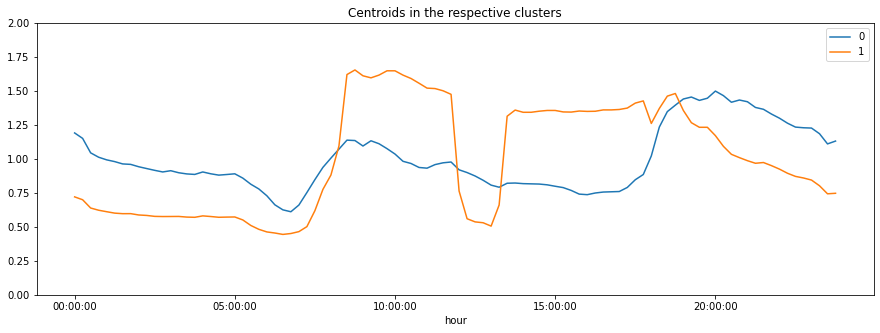

In [55]:
cdf_f.plot(figsize=(15,5), legend=False, ylim=(0, 2))
plt.title('Centroids in the respective clusters')
plt.legend()
plt.show()

In [56]:
clusterdf= pd.DataFrame(data=kmeans.labels_, columns=['ClusterNo'])
#clusterdf.index = X.index
clusterdf

,ClusterNo
0,0
1,1
2,1
3,1
4,0
...,...
725,0
726,0
727,1
728,1


In [57]:
df_all1 = pd.concat([df_Z, clusterdf], axis=1)
df_all1

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,ClusterNo
0,1.372998,1.263158,1.208238,1.098398,1.070938,1.153318,1.153318,1.098398,1.180778,1.043478,...,1.235698,1.180778,1.180778,1.098398,1.153318,1.208238,1.180778,1.043478,1.070938,0
1,0.745149,0.745149,0.683053,0.683053,0.745149,0.724450,0.662354,0.765847,0.683053,0.703752,...,0.952135,0.890039,0.952135,0.890039,0.827943,0.765847,0.765847,0.786546,0.807245,1
2,0.697385,0.677460,0.657534,0.637609,0.617684,0.657534,0.577833,0.597758,0.577833,0.557908,...,1.016189,1.036115,1.056040,0.936488,0.856787,0.896638,0.856787,0.896638,0.836862,1
3,0.748768,0.709360,0.709360,0.689655,0.709360,0.650246,0.669951,0.669951,0.689655,0.689655,...,0.866995,0.886700,0.866995,0.886700,0.847291,0.945813,0.906404,0.847291,0.788177,1
4,0.812054,0.786677,0.812054,0.786677,0.735924,0.761301,0.735924,0.735924,0.735924,0.786677,...,1.344964,1.116574,1.116574,1.243458,1.192704,1.218081,1.243458,1.065821,1.141951,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,0.702691,0.723358,0.702691,0.682024,0.723358,0.702691,0.661356,0.661356,0.661356,0.640689,...,1.281378,1.198708,1.260710,1.240043,1.198708,1.240043,1.178041,1.074704,0.950700,0
726,1.102435,1.036288,0.992191,0.992191,0.926045,0.881948,0.881948,0.903996,0.903996,0.903996,...,1.367019,1.344970,1.146532,1.146532,1.058337,1.168581,1.190629,1.058337,0.926045,0
727,0.787025,0.821244,0.752807,0.787025,0.735698,0.718588,0.735698,0.718588,0.735698,0.701479,...,0.941009,0.872572,0.855462,0.906790,0.906790,0.992336,0.992336,0.889681,0.821244,1
728,0.836795,0.854599,0.872404,0.818991,0.801187,0.783383,0.818991,0.783383,0.818991,0.765579,...,0.961424,0.801187,0.729970,0.747774,0.783383,0.836795,0.854599,0.694362,0.676558,1


Cluster No.: 0
Number of Clients: 211


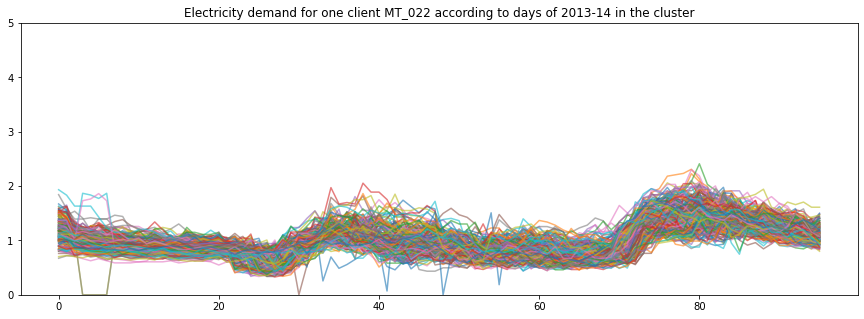

-----------------------------------------------------------------------------------
Cluster No.: 1
Number of Clients: 519


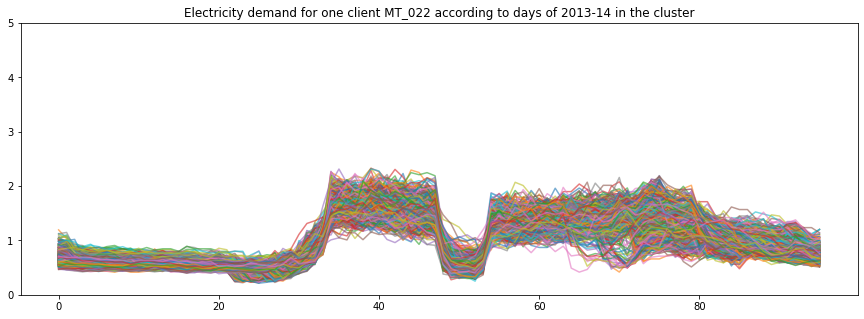

-----------------------------------------------------------------------------------


In [58]:
for ClusterNo in df_all1['ClusterNo'].sort_values().unique():
    df_plot = df_all1[df_all1['ClusterNo']==ClusterNo].T.drop('ClusterNo')
    print('Cluster No.: ' + str(ClusterNo))    
    print('Number of Clients: ' + str(len(df_plot.T)))
    df_plot.plot(figsize=(15,5),alpha=0.6,legend=False, ylim=(0, 5))
    plt.title('Electricity demand for one client MT_022 according to days of 2013-14 in the cluster')
    plt.show()
    print('-----------------------------------------------------------------------------------')

#### Analysis based on Days and Months :

In [59]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
days = []
# monthx = [] 
D = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])
    days.extend([D[(d1+timedelta(days=i)).weekday()]])
    

In [60]:
daysyear

['Tue-2013-01-01',
 'Wed-2013-01-02',
 'Thu-2013-01-03',
 'Fri-2013-01-04',
 'Sat-2013-01-05',
 'Sun-2013-01-06',
 'Mon-2013-01-07',
 'Tue-2013-01-08',
 'Wed-2013-01-09',
 'Thu-2013-01-10',
 'Fri-2013-01-11',
 'Sat-2013-01-12',
 'Sun-2013-01-13',
 'Mon-2013-01-14',
 'Tue-2013-01-15',
 'Wed-2013-01-16',
 'Thu-2013-01-17',
 'Fri-2013-01-18',
 'Sat-2013-01-19',
 'Sun-2013-01-20',
 'Mon-2013-01-21',
 'Tue-2013-01-22',
 'Wed-2013-01-23',
 'Thu-2013-01-24',
 'Fri-2013-01-25',
 'Sat-2013-01-26',
 'Sun-2013-01-27',
 'Mon-2013-01-28',
 'Tue-2013-01-29',
 'Wed-2013-01-30',
 'Thu-2013-01-31',
 'Fri-2013-02-01',
 'Sat-2013-02-02',
 'Sun-2013-02-03',
 'Mon-2013-02-04',
 'Tue-2013-02-05',
 'Wed-2013-02-06',
 'Thu-2013-02-07',
 'Fri-2013-02-08',
 'Sat-2013-02-09',
 'Sun-2013-02-10',
 'Mon-2013-02-11',
 'Tue-2013-02-12',
 'Wed-2013-02-13',
 'Thu-2013-02-14',
 'Fri-2013-02-15',
 'Sat-2013-02-16',
 'Sun-2013-02-17',
 'Mon-2013-02-18',
 'Tue-2013-02-19',
 'Wed-2013-02-20',
 'Thu-2013-02-21',
 'Fri-2013-0

In [61]:
clusterdf.head(2)

,ClusterNo
0,0
1,1


In [62]:
clusterdf= pd.DataFrame(data=kmeans.labels_, index = [daysyear], columns=['ClusterNo'])
clusterdf["Day"]= days
clusterdf["Dates"]= clusterdf.index
clusterdf.head(2)

,ClusterNo,Day,Dates
Tue-2013-01-01,0,Tue,"(Tue-2013-01-01,)"
Wed-2013-01-02,1,Wed,"(Wed-2013-01-02,)"


In [63]:
clusterdf1 = pd.DataFrame(clusterdf).set_index('Dates')
clusterdf1.index.name
clusterdf1.head(2)

,ClusterNo,Day
Dates,,
"(Tue-2013-01-01,)",0,Tue
"(Wed-2013-01-02,)",1,Wed


In [64]:
from datetime import datetime
clusterdf["Dates"] = [x_[0] for x_ in clusterdf["Dates"]]
clusterdf["Dates"]

Tue-2013-01-01    Tue-2013-01-01
Wed-2013-01-02    Wed-2013-01-02
Thu-2013-01-03    Thu-2013-01-03
Fri-2013-01-04    Fri-2013-01-04
Sat-2013-01-05    Sat-2013-01-05
                       ...      
Sat-2014-12-27    Sat-2014-12-27
Sun-2014-12-28    Sun-2014-12-28
Mon-2014-12-29    Mon-2014-12-29
Tue-2014-12-30    Tue-2014-12-30
Wed-2014-12-31    Wed-2014-12-31
Name: Dates, Length: 730, dtype: object

In [65]:
clusterdf["Date"] = clusterdf.Dates.apply(lambda x: x[9:11])
clusterdf.head(2)

,ClusterNo,Day,Dates,Date
Tue-2013-01-01,0,Tue,Tue-2013-01-01,01
Wed-2013-01-02,1,Wed,Wed-2013-01-02,01


In [66]:
M = {'01':'Jan', '02':'Feb', '03':'Mar', '04':'Apr', '05':'May', '06':'Jun', '07':'Jul', '08':'Aug', '09':'Sep', '10':'Oct', '11':'Nov', '12':'Dec'}

In [67]:
clusterdf["Month"]= clusterdf.Date.map(M)
clusterdf.head(10)

,ClusterNo,Day,Dates,Date,Month
Tue-2013-01-01,0,Tue,Tue-2013-01-01,01,Jan
Wed-2013-01-02,1,Wed,Wed-2013-01-02,01,Jan
Thu-2013-01-03,1,Thu,Thu-2013-01-03,01,Jan
Fri-2013-01-04,1,Fri,Fri-2013-01-04,01,Jan
Sat-2013-01-05,0,Sat,Sat-2013-01-05,01,Jan
Sun-2013-01-06,0,Sun,Sun-2013-01-06,01,Jan
Mon-2013-01-07,1,Mon,Mon-2013-01-07,01,Jan
Tue-2013-01-08,1,Tue,Tue-2013-01-08,01,Jan
Wed-2013-01-09,1,Wed,Wed-2013-01-09,01,Jan
Thu-2013-01-10,1,Thu,Thu-2013-01-10,01,Jan


In [68]:
cluster_day = pd.DataFrame(clusterdf, columns=['ClusterNo', 'Day']).reset_index(drop=True)
cluster_day.head(2)

,ClusterNo,Day
0,0,Tue
1,1,Wed


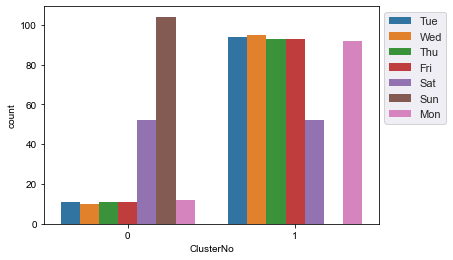

In [69]:
sns.countplot(x=cluster_day['ClusterNo'], hue= cluster_day['Day'], data=cluster_day)
sns.set(color_codes=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [70]:
cluster_Month = pd.DataFrame(clusterdf, columns=['ClusterNo', 'Month']).reset_index(drop=True)
cluster_Month

,ClusterNo,Month
0,0,Jan
1,1,Jan
2,1,Jan
3,1,Jan
4,0,Jan
...,...,...
725,0,Dec
726,0,Dec
727,1,Dec
728,1,Dec


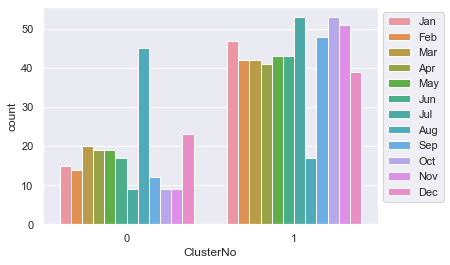

In [71]:
sns.countplot(x=cluster_Month['ClusterNo'], hue= cluster_Month['Month'], data=cluster_Month)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))